In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

filename = "metadata.json"
with open(filename, 'r') as file:
    data = json.load(file)
    print('Dataset Metadata:')
print(json.dumps(data, indent=4))

## Socioeconomic Community Snapshot Data from CSV file

In [1]:
'''# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

path_css = 'data/comm_snapshot/Community_Data_Snapshots_2024_3269398054420983008.csv'
data_css = pd.read_csv(path_css, header=0)'''
from used_packages import *
from utils import *

path_css = 'data/comm_snapshot/CCA - Community_Data_Snapshots_2024_3269398054420983008.csv'
data_css = pd.read_csv(path_css, header=0)
data_css['GEOID'] = data_css['GEOID'].astype('category')


## Crime Data from API

In [2]:
'''import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", "qX6sPDfNj5gT01n8nCW3uklAj")

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ijzp-q8t2", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)'''

'import pandas as pd\nfrom sodapy import Socrata\n\n# Unauthenticated client only works with public data sets. Note \'None\'\n# in place of application token, and no username or password:\nclient = Socrata("data.cityofchicago.org", "qX6sPDfNj5gT01n8nCW3uklAj")\n\n# Example authenticated client (needed for non-public datasets):\n# client = Socrata(data.cityofchicago.org,\n#                  MyAppToken,\n#                  username="user@example.com",\n#                  password="AFakePassword")\n\n# First 2000 results, returned as JSON from API / converted to Python list of\n# dictionaries by sodapy.\nresults = client.get("ijzp-q8t2", limit=2000)\n\n# Convert to pandas DataFrame\nresults_df = pd.DataFrame.from_records(results)'

## Crime Data from CSV file

In [4]:
'''# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

path_crime = 'data/crime_data/Crimes_-_2001_to_Present.csv'
data_csv = pd.read_csv(path_crime, header=0)'''


"# make sure to install these packages before running:\n# pip install pandas\n# pip install sodapy\n\npath_crime = 'data/crime_data/Crimes_-_2001_to_Present.csv'\ndata_csv = pd.read_csv(path_crime, header=0)"

In [5]:
from used_packages import *
from utils import *

# load cleaned crime data from 2015
path_crime_clean = 'data/crime_data/crime_data_clean_2015.csv'
data_csv_clean = pd.read_csv(path_crime_clean, header=0)

cat_cols = ['ID', 'Case Number', 'Block', 'IUCR', 'Primary Type', 'Description',
            'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
            'Ward', 'Community Area', 'FBI Code']
#data_csv_clean[cat_cols] = data_csv_clean[cat_cols].astype('category')

'''data_csv_clean[['Community Area', 'District', 'Ward']] = (
    data_csv_clean[['Community Area', 'District', 'Ward']]
    .apply(lambda x: x.map(lambda v: f"{int(v)}" if pd.notna(v) else v))
    .astype('category')
)'''

'''data_csv_clean['Ward'] = data_csv_clean['Ward'].cat.add_categories('NA')
data_csv_clean['District'] = data_csv_clean['District'].cat.add_categories('NA')'''

data_csv_clean['Ward'] = data_csv_clean['Ward'].fillna(-1)
data_csv_clean['District'] = data_csv_clean['District'].fillna(-1)

# Merge crime data with community snapshot (CSS)

Merge Community snapshot dataset with the crime data and group by community area

In [6]:
crimes_by_area = data_csv_clean.groupby('Community Area')['ID'].count().reset_index()
crimes_by_area.columns = ['CA', 'Crime_Count']
#crimes_by_area['CA'] = crimes_by_area['CA'].astype('int').astype('category')

# Merge with community data
merged_df1 = pd.merge(crimes_by_area, data_css,
                       left_on='CA',
                       right_on='GEOID',
                       how='left').drop('GEOID', axis=1)

comm_areas = {d['CA']: d['GEOG'] for _, d in merged_df1.iterrows()}

# Create response variable
merged_df1['Crime_Rate'] = merged_df1['Crime_Count'] / merged_df1['2020_POP'] * 1000

In [7]:
data_csv_clean.head(10)

,ID,Community Area,Day,Month,Year,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,FBI Code,IUCR,Case Number,Block,Latitude,Longitude
0,25953,19.0,24,5,2021,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2515,25.0,36.0,01A,0110,JE240540,020XX N LARAMIE AVE,41.917838,-87.755969
1,26038,13.0,26,6,2021,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,1711,17.0,50.0,01A,0110,JE279849,062XX N MC CORMICK RD,41.995219,-87.713355
2,13279676,5.0,9,11,2023,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,1922,19.0,47.0,05,0620,JG507211,019XX W BYRON ST,41.952345,-87.677975
3,13274752,44.0,12,11,2023,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,632,6.0,6.0,08B,0454,JG501049,086XX S COTTAGE GROVE AVE,41.737751,-87.604856
4,13203321,32.0,6,9,2023,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.0,42.0,14,1320,JG415333,002XX N Wells st,41.886018,-87.633938
5,13582916,76.0,1,7,2024,DECEPTIVE PRACTICE,"THEFT BY LESSEE, MOTOR VEHICLE",AIRPORT EXTERIOR - NON-SECURE AREA,False,False,1654,16.0,41.0,11,1206,JH406913,102XX W ZEMKE RD,41.994914,-87.881938
6,28339,23.0,25,8,2024,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,1121,11.0,27.0,01A,0110,JH394658,033XX W OHIO ST,41.891851,-87.710503
7,13617993,66.0,1,4,2024,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,823,8.0,14.0,08B,0486,JH453090,060XX S ALBANY AVE,41.783844,-87.700843
8,12651978,33.0,24,3,2022,MOTOR VEHICLE THEFT,AUTOMOBILE,GAS STATION,False,False,131,1.0,34.0,07,0910,JF185322,012XX S WABASH AVE,41.866844,-87.625817
9,13210088,28.0,31,8,2023,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,STREET,False,False,1225,12.0,27.0,11,1153,JG423627,023XX W JACKSON BLVD,41.877565,-87.684791


In [8]:
print(f'Number of Districts: {len(np.unique(data_csv_clean["District"]))}')
print(f'Number of Beats: {len(np.unique(data_csv_clean["Beat"]))}')
print(f'Number of Community Areas: {len(np.unique(data_csv_clean["Community Area"]))}')
print(f'Number of Wards: {len(np.unique(data_csv_clean["Ward"]))}')
print(f'Unique Community Areas: {np.unique(data_csv_clean["Community Area"])}')

Number of Districts: 24
Number of Beats: 275
Number of Community Areas: 77
Number of Wards: 51
Unique Community Areas: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77.]


### Extracting geo coordinates of a random Community Area and confirming it aligns with Community Snapshot Data - Answer is Yes
### CA 77 is Edgewater in the snapshot dataset. Coords of CA 77 here all point to Edgewater on google maps

In [9]:
CA_no = 24
CA_coord = data_csv_clean[data_csv_clean['Community Area'] == CA_no][['Latitude', 'Longitude']]
CA_nan = data_csv_clean[data_csv_clean['Community Area'] == np.nan][['Latitude', 'Longitude']]
CA_0 = data_csv_clean[data_csv_clean['Community Area'] == 0][['Latitude', 'Longitude']]
print(f'Local Community Area [{CA_no}] - map coordinates: {CA_coord.values}')
print(f'Local Community Area [NaN] - map coordinates: {CA_nan.values}')
print(f'Number of Community Areas with 0 Labels (likely lying at the edge between CAs): {len(CA_0)}')
print(f'Local Community Area [0] - map coordinates: {CA_0.values}')

Local Community Area [24] - map coordinates: [[ 41.89850206 -87.69924242]
 [ 41.91065261 -87.66614577]
 [ 41.91096238 -87.69455985]
 ...
 [ 41.90846836 -87.67664595]
 [ 41.89519912 -87.66460973]
 [ 41.9033043  -87.67006468]]
Local Community Area [NaN] - map coordinates: []
Number of Community Areas with 0 Labels (likely lying at the edge between CAs): 0
Local Community Area [0] - map coordinates: []


In [10]:
CA = data_csv_clean[['Longitude', 'Latitude', 'Community Area']]

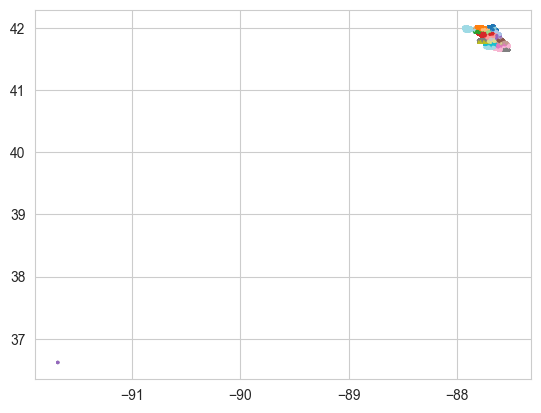

In [11]:
plt.scatter(CA.iloc[:,0], CA.iloc[:, 1], c=CA.iloc[:, 2], cmap='tab20', s=2)
plt.show()

### geo coords [36.619446395,-91.686565684] seems to be placeholder for unditentified coords. While some of these datapoints do not have Community Area specified, some do have valid CA label.


### Dropping those geo coords and replot

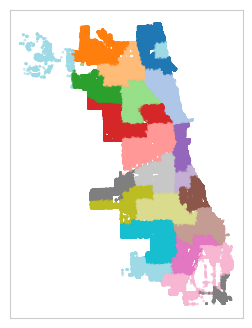

In [12]:
idx_geo_na = (CA['Longitude'] > -88)
plt.figure(figsize=(3, 4))
plt.scatter(CA[idx_geo_na].iloc[:, 0], CA[idx_geo_na].iloc[:, 1], c=CA[idx_geo_na].iloc[:, 2], cmap='tab20', s=1, alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

https://chibarproject.com/wp-content/uploads/2021/09/Chicago-interactive-map-1.jpg

### Geo coords of crimes align with chicago map - colored by Community Area

In [13]:
#Merge Data and take pertinent rows
#data_css.head(10) - community snapshot
#crimes_2015.head(10) - crime

css = [ 'CA', 'Crime_Rate', '2020_POP', \
        'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', #Employment predictors
        'TOT_WRKR16OV', 'WORK_AT_HOME' , 'TOT_COMM', 'DROVE_AL', 'CARPOOL', 'TRANSIT', 'WALK_BIKE', 'COMM_OTHER', #transit predictors
        'NO_VEH', 'ONE_VEH', 'TWO_VEH', 'THREEOM_VEH', #vehicle/transit predictors cont.
        'LT_HS', 'HS', 'SOME_COLL', 'ASSOC', 'BACH', 'GRAD_PROF', #Education predictors
        'INC_LT_25K', 'INC_25_50K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150', 'MEDINC', 'INCPERCAP'] #Income predictors

'''
# Drop rows with missing community area values
crimes = data_csv_clean[['Community Area', 'Primary Type']]
crimes = crimes.dropna(subset=['Community Area'])

# Aggregate crime count by Community Area
print("Aggregating crime data by community area...")
crime_counts = crimes.groupby("Community Area").size().reset_index(name="Crime_Count")

# Merge with community data using GEOID (Community Area ID)
print("Merging with community data...")
css = css.rename(columns={'GEOID': 'Community Area'})  # Rename for easier merge
merged_df = css.merge(crime_counts, on="Community Area", how="left")'''

# Fill NaN crime counts with 0 (for community areas without crime records)
merged_df = merged_df1[css]

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CA            77 non-null     object 
 1   Crime_Rate    77 non-null     float64
 2   2020_POP      77 non-null     int64  
 3   IN_LBFRC      77 non-null     float64
 4   EMP           77 non-null     float64
 5   UNEMP         77 non-null     float64
 6   NOT_IN_LBFRC  77 non-null     float64
 7   TOT_WRKR16OV  77 non-null     float64
 8   WORK_AT_HOME  77 non-null     float64
 9   TOT_COMM      77 non-null     float64
 10  DROVE_AL      77 non-null     float64
 11  CARPOOL       77 non-null     float64
 12  TRANSIT       77 non-null     float64
 13  WALK_BIKE     77 non-null     float64
 14  COMM_OTHER    77 non-null     float64
 15  NO_VEH        77 non-null     float64
 16  ONE_VEH       77 non-null     float64
 17  TWO_VEH       77 non-null     float64
 18  THREEOM_VEH   77 non-null     fl

### Boxplot of Predictors

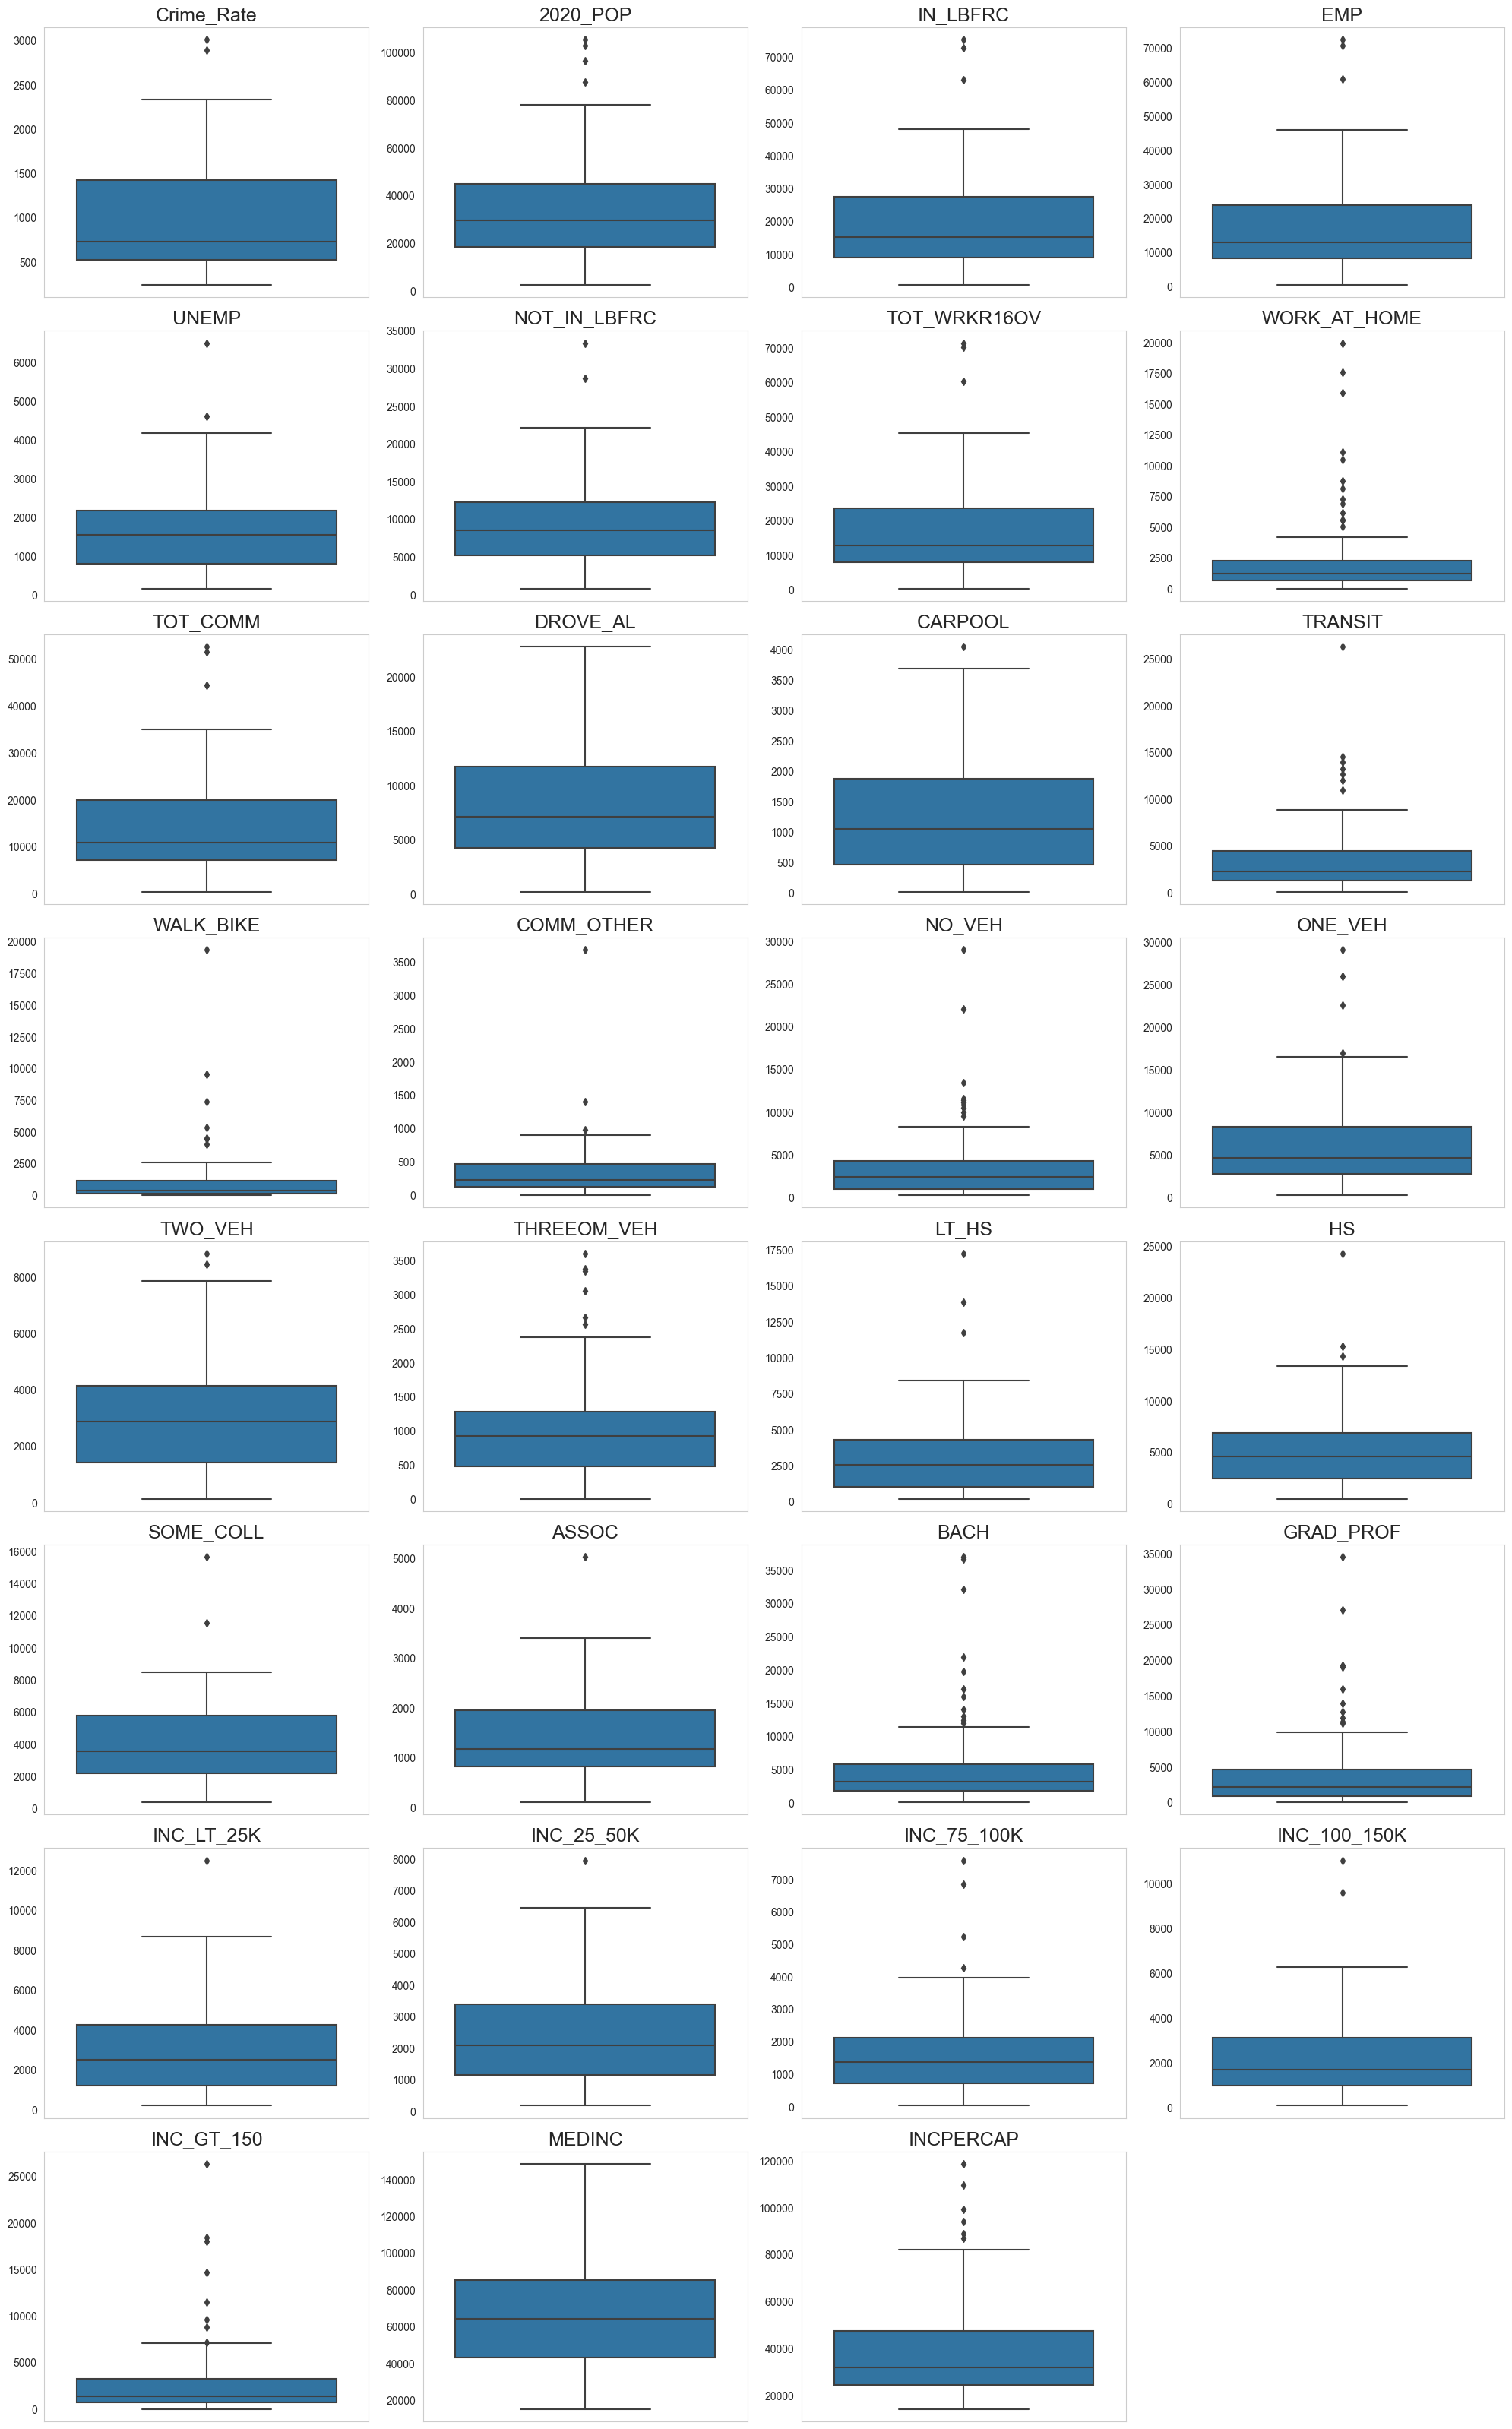

In [14]:
import seaborn as sns

# Define grid size (adjust based on the number of columns)
num_cols = len(merged_df)
rows = (num_cols // 4) + (num_cols % 4 > 0)

# Set figure size
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 4))
axes = axes.flatten()

# Create boxplots
for i, col in enumerate(merged_df.drop(columns=['CA'])):
    sns.boxplot(y=merged_df[col], ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=18)  # Increased font size
    axes[i].set_ylabel('')
    axes[i].grid(False)  # Remove grid for each subplot

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig('eda_boxplots.pdf')
plt.show()

Early EDA shows a handful of outliers in most predictors.

### Scatterplot of Predictors

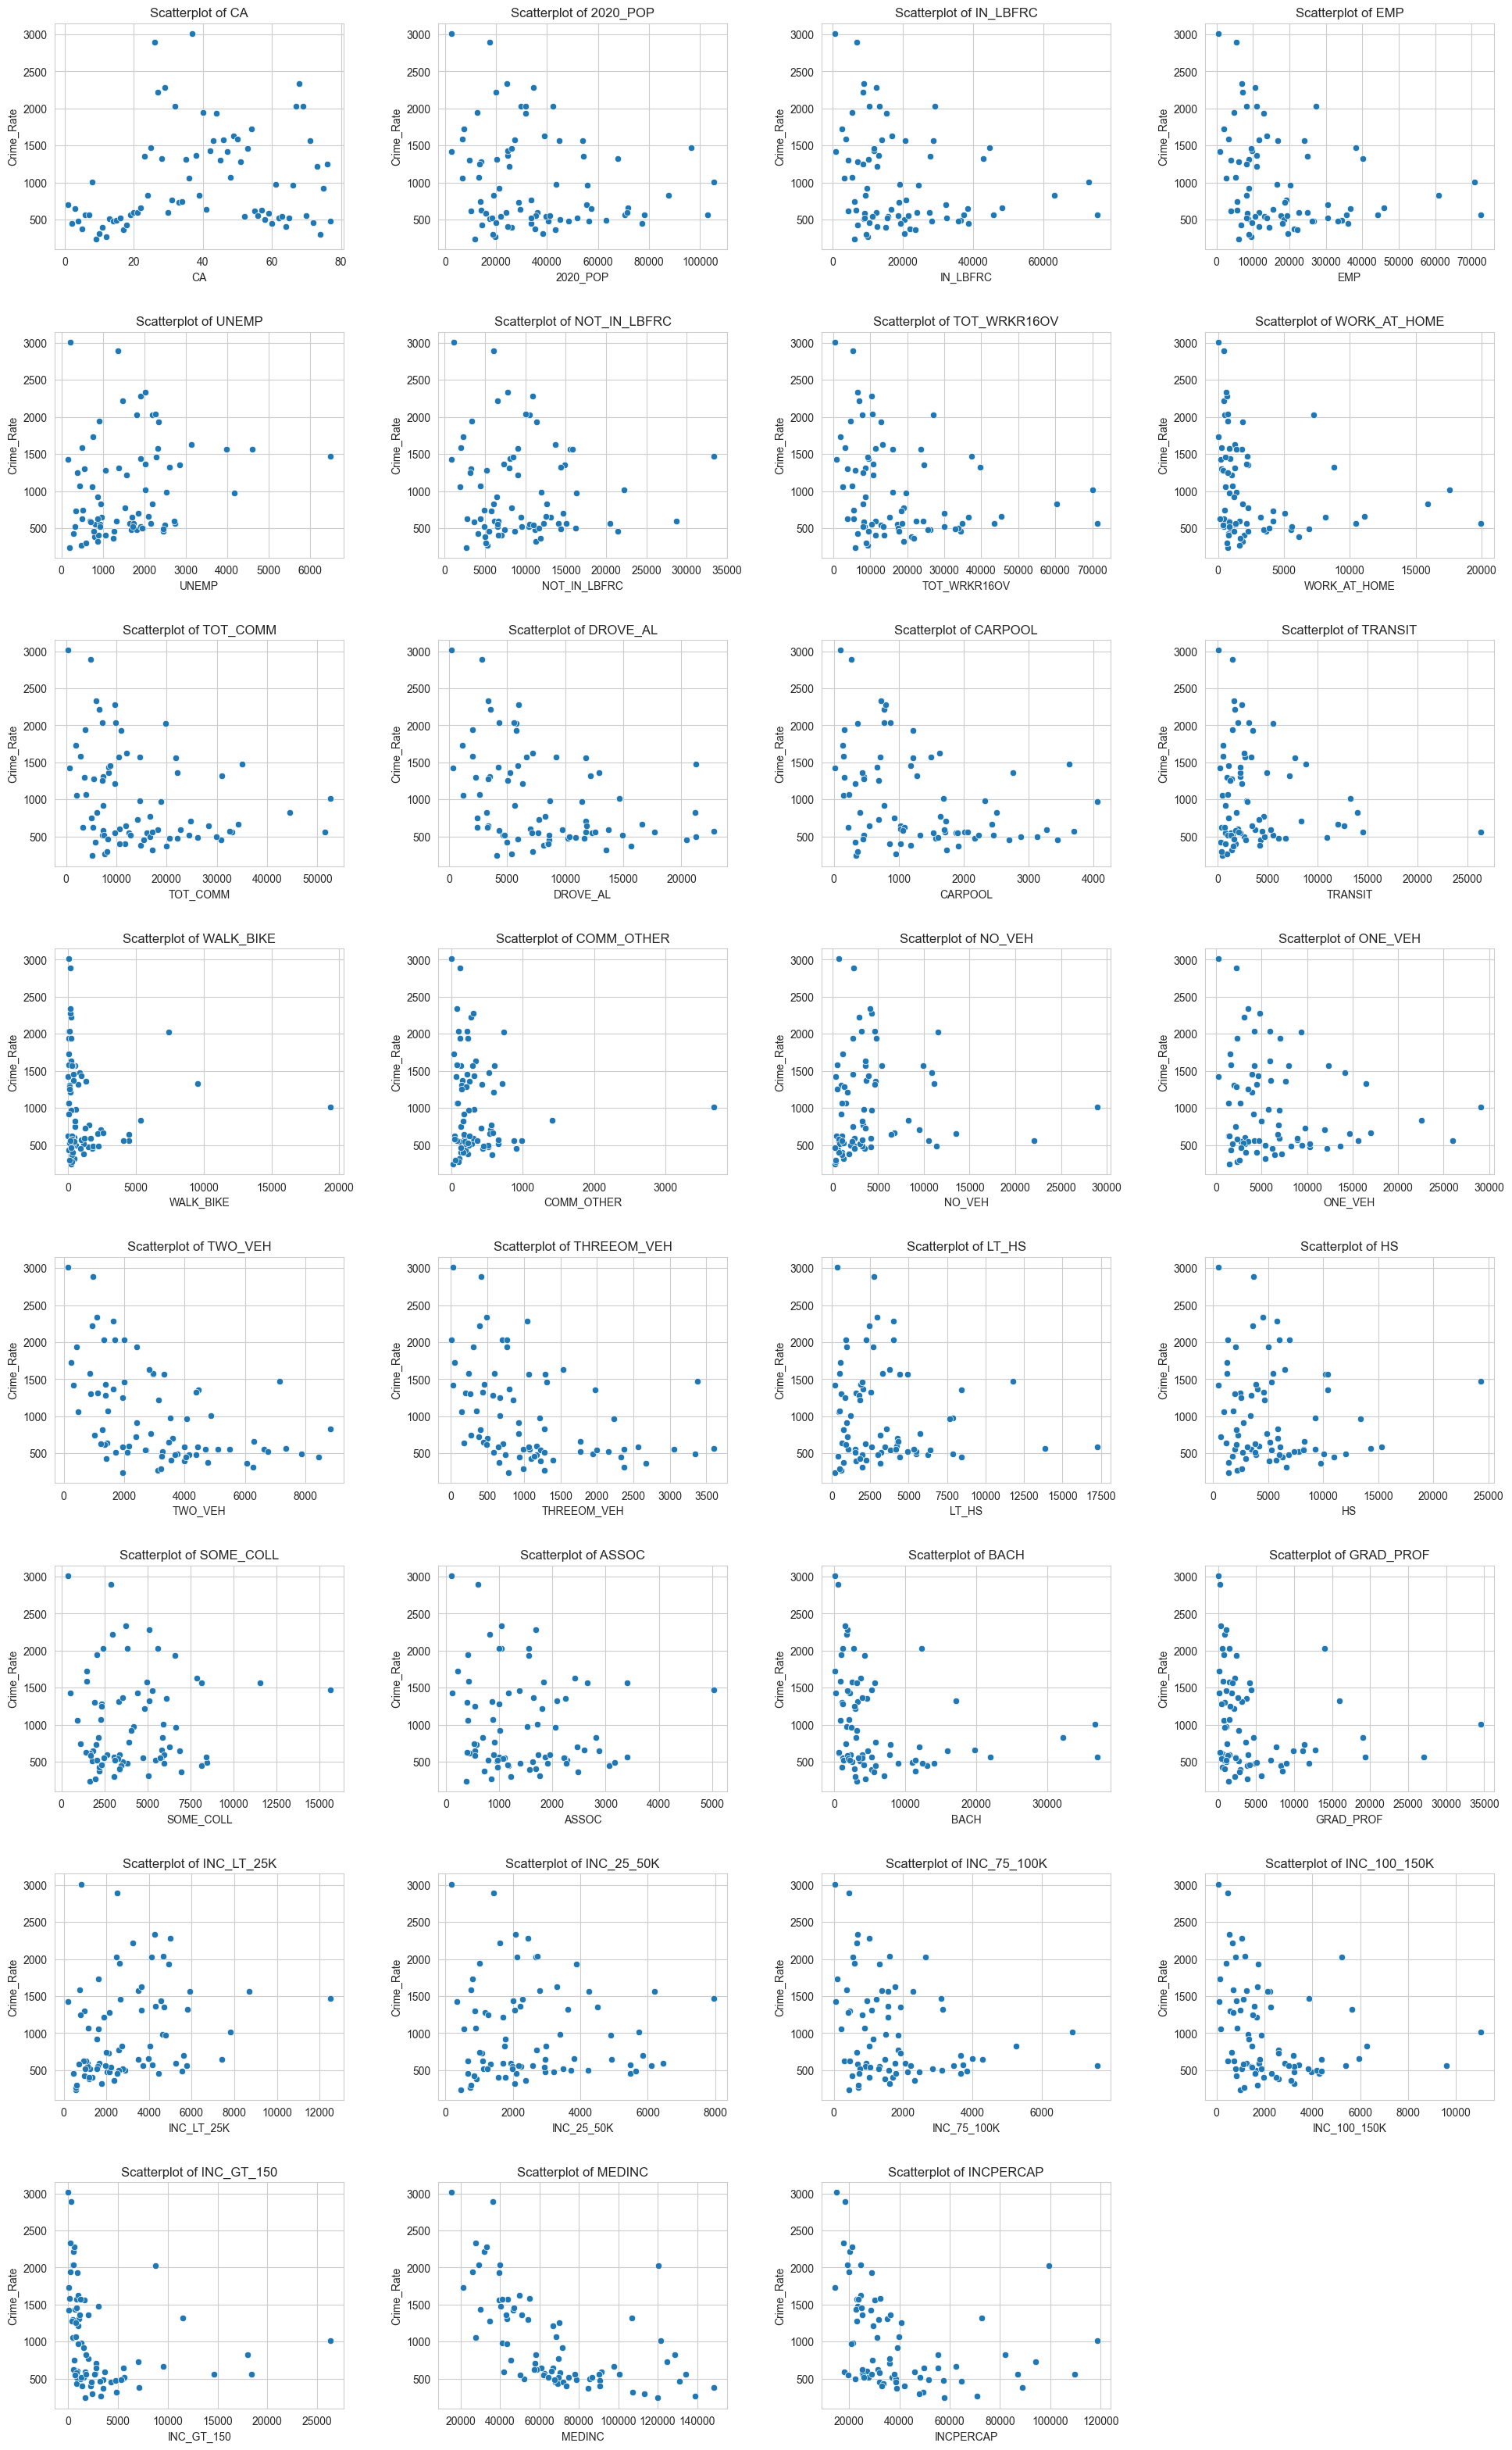

In [15]:
# Define grid size (adjust based on the number of columns)
df_sans_crime = merged_df.columns.drop('Crime_Rate')
num_cols = len(df_sans_crime)
rows = (num_cols // 4) + (num_cols % 4 > 0)

# Set figure size
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 4))
axes = axes.flatten()

# Create scatterplots
for i, col in enumerate(df_sans_crime): #Use df_sans_crime to exclude crime count
    sns.scatterplot(x = merged_df[col], y = merged_df['Crime_Rate'], data=merged_df, ax=axes[i])
    axes[i].set_title(f'Scatterplot of {col}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3)
plt.show()

### Correlation Chart

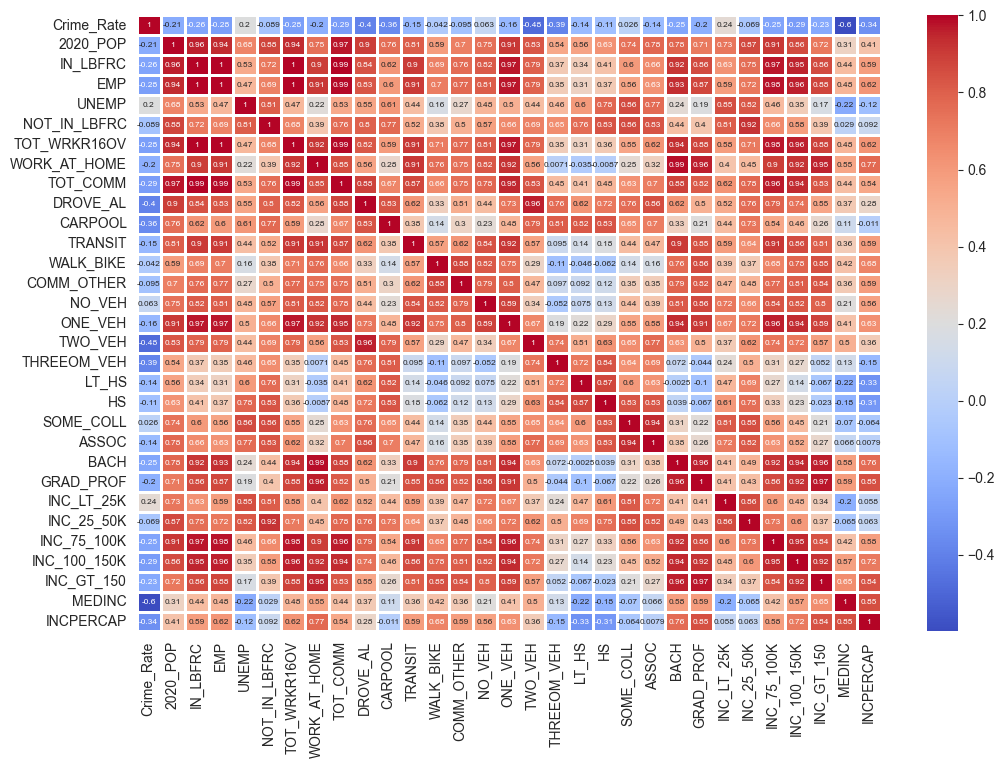

In [16]:
#Make sure all columns are in the right type and only those are selected
numeric_columns = merged_df.select_dtypes(['float64','int64'])

plt.figure(figsize=(12, 8))

sns.heatmap(numeric_columns.corr(), cmap='coolwarm', linewidth=1, annot=True, annot_kws={"size": 6})

#plt.title('Variable Correlation')
plt.savefig('eda_heatmaps.pdf')
plt.show()

There's a lot of correlation between similar predictors. We'll likely have to manually eliminate some predictors before even performing variable selection.

### Selected outliers
This section easily be adapted to find other outliers that warrant invesigation. While there are many outliers that can be investigated, I did one on the one area that is much more populated and stands to be an outlier so it'd be good to investigate it further. I've left outliers in the analysis since we currently don't have SME or pertinent background knowledge to remove any odd points.

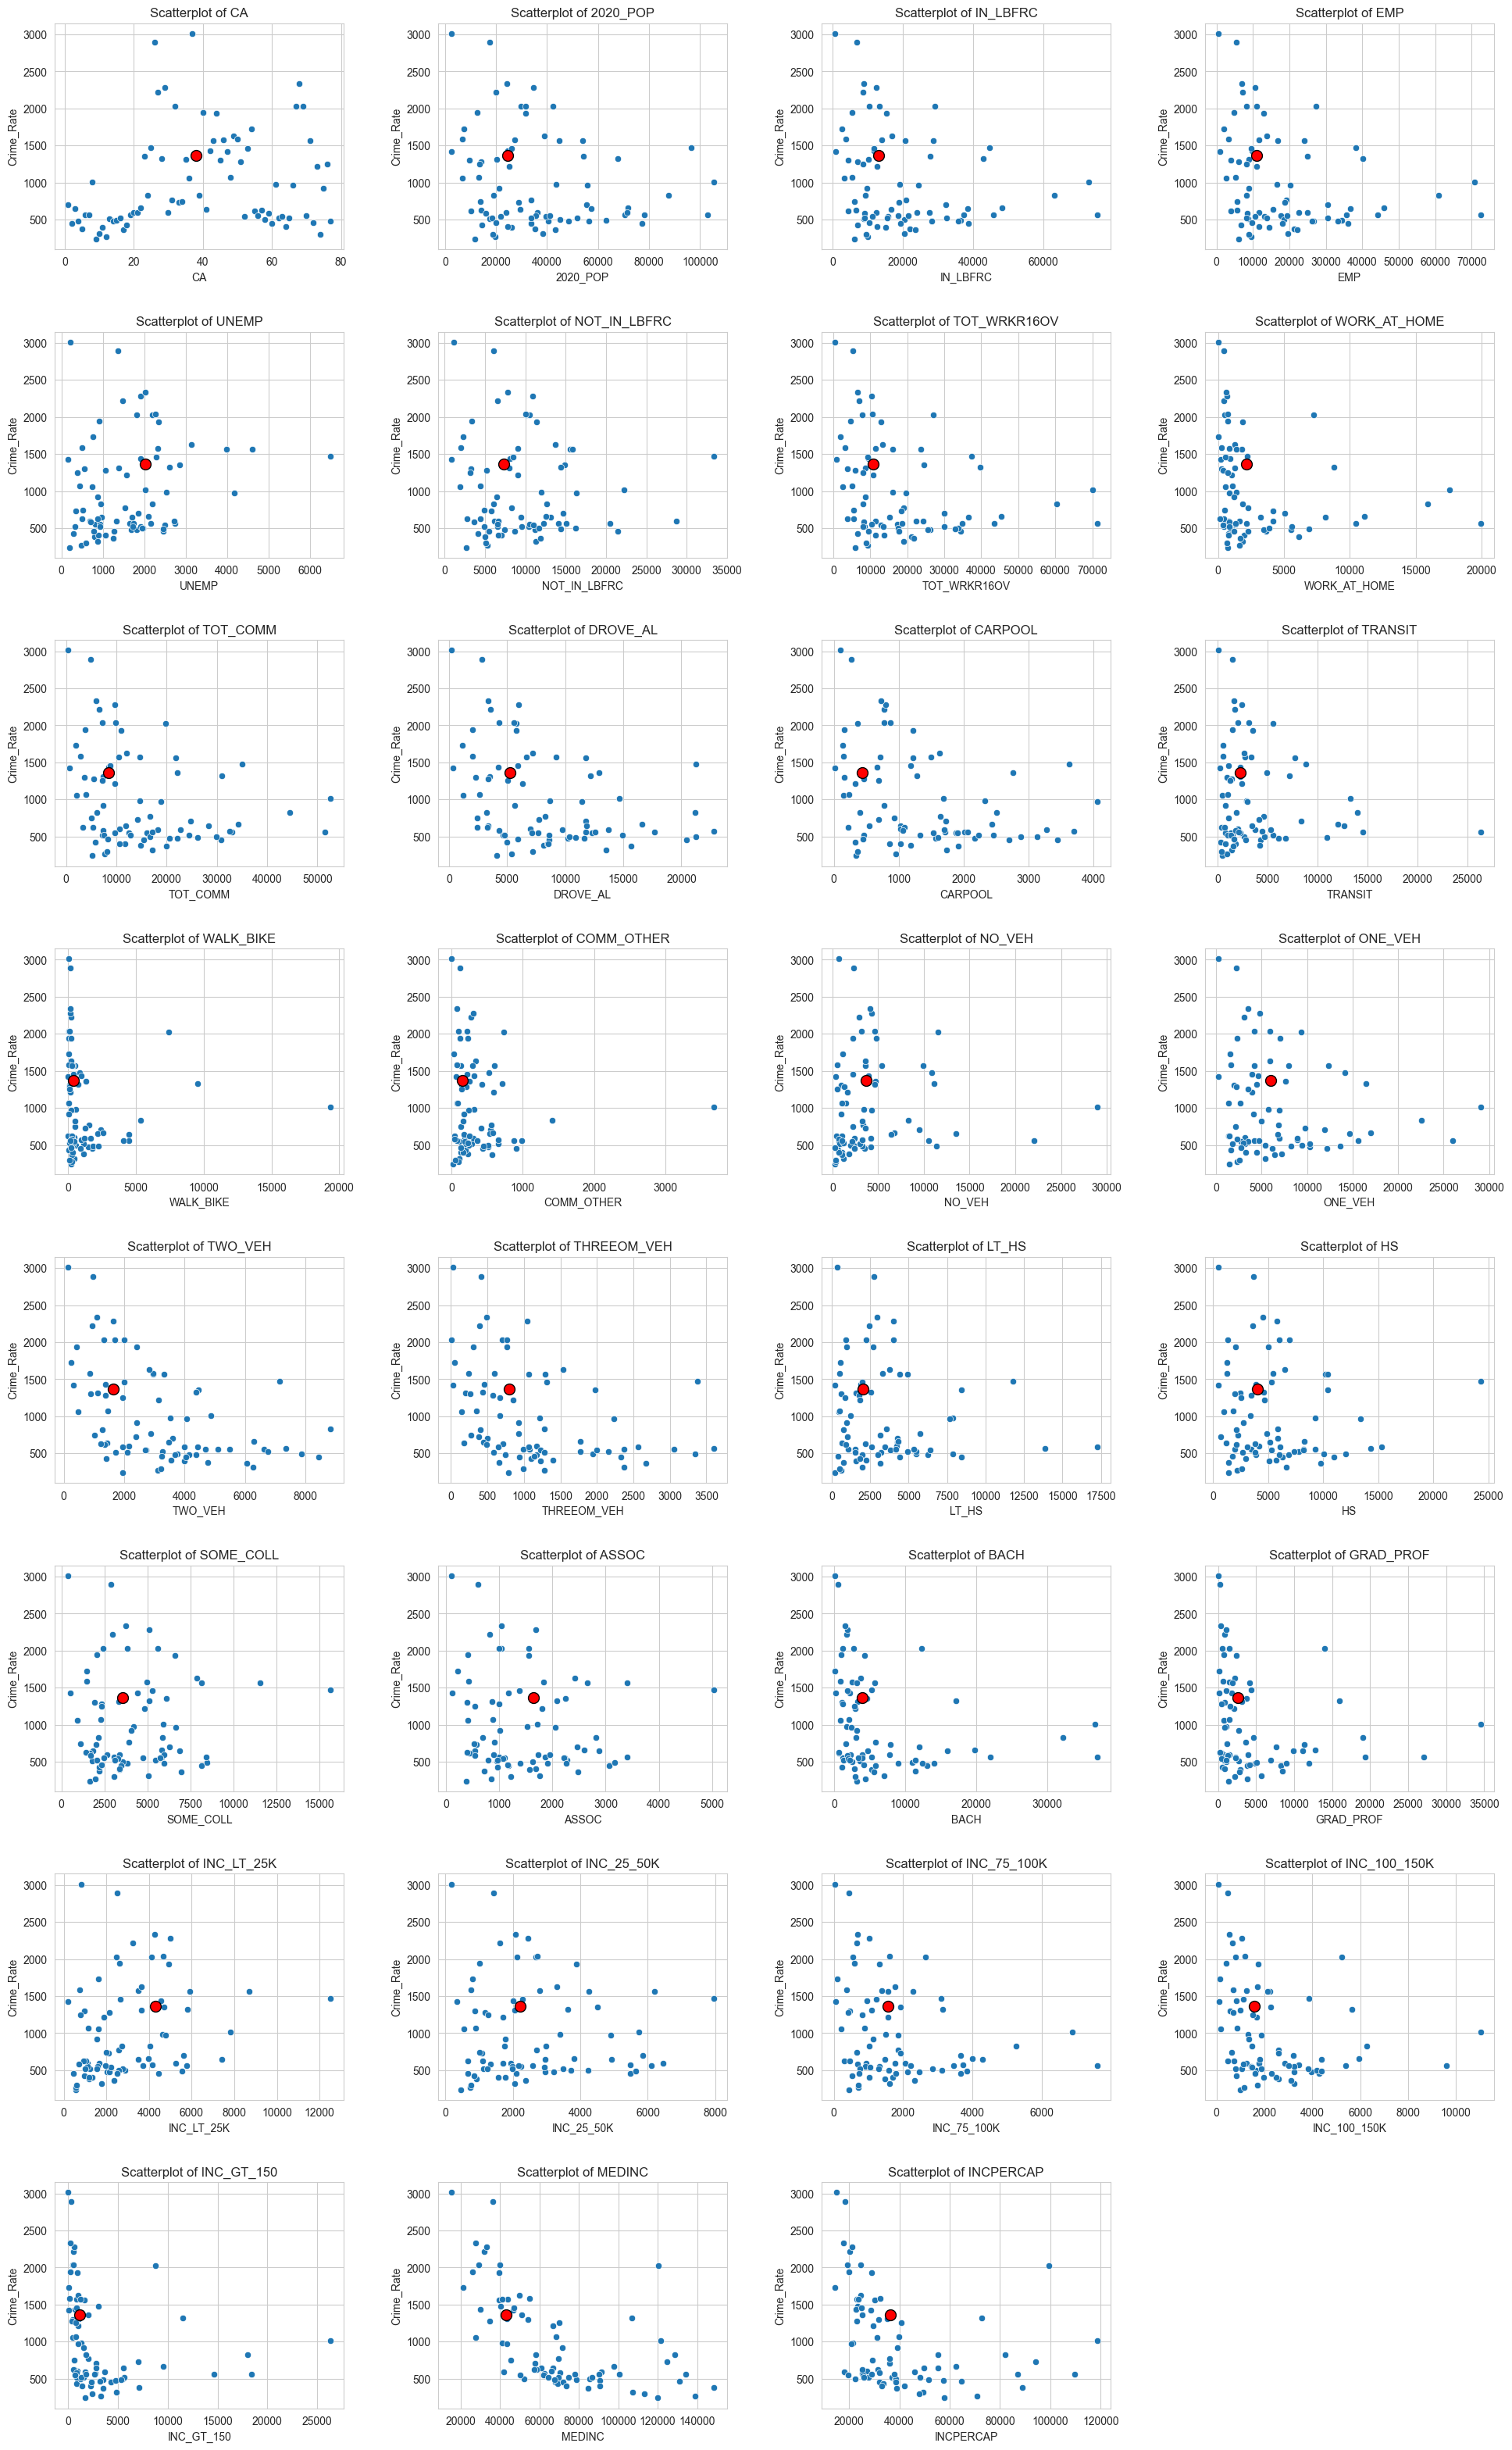

In [17]:
largest_area = merged_df.loc[merged_df['Crime_Rate'].idxmax(), 'CA']
largest_area #Community Area 25

# Set figure size
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 4))
axes = axes.flatten()

# Create scatterplots
for i, col in enumerate(df_sans_crime): #Use df_sans_crime to exclude crime  count
    sns.scatterplot(x = merged_df[col], y = merged_df['Crime_Rate'], data=merged_df, ax=axes[i])
    axes[i].set_title(f'Scatterplot of {col}')

    # Highlight a specific point
    axes[i].scatter(
        merged_df[col].loc[largest_area], merged_df['Crime_Rate'].loc[largest_area],
        color='red', s=100, edgecolors='black', label="Highlighted Point"
    )
    
# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3)
plt.show()

### Histograms

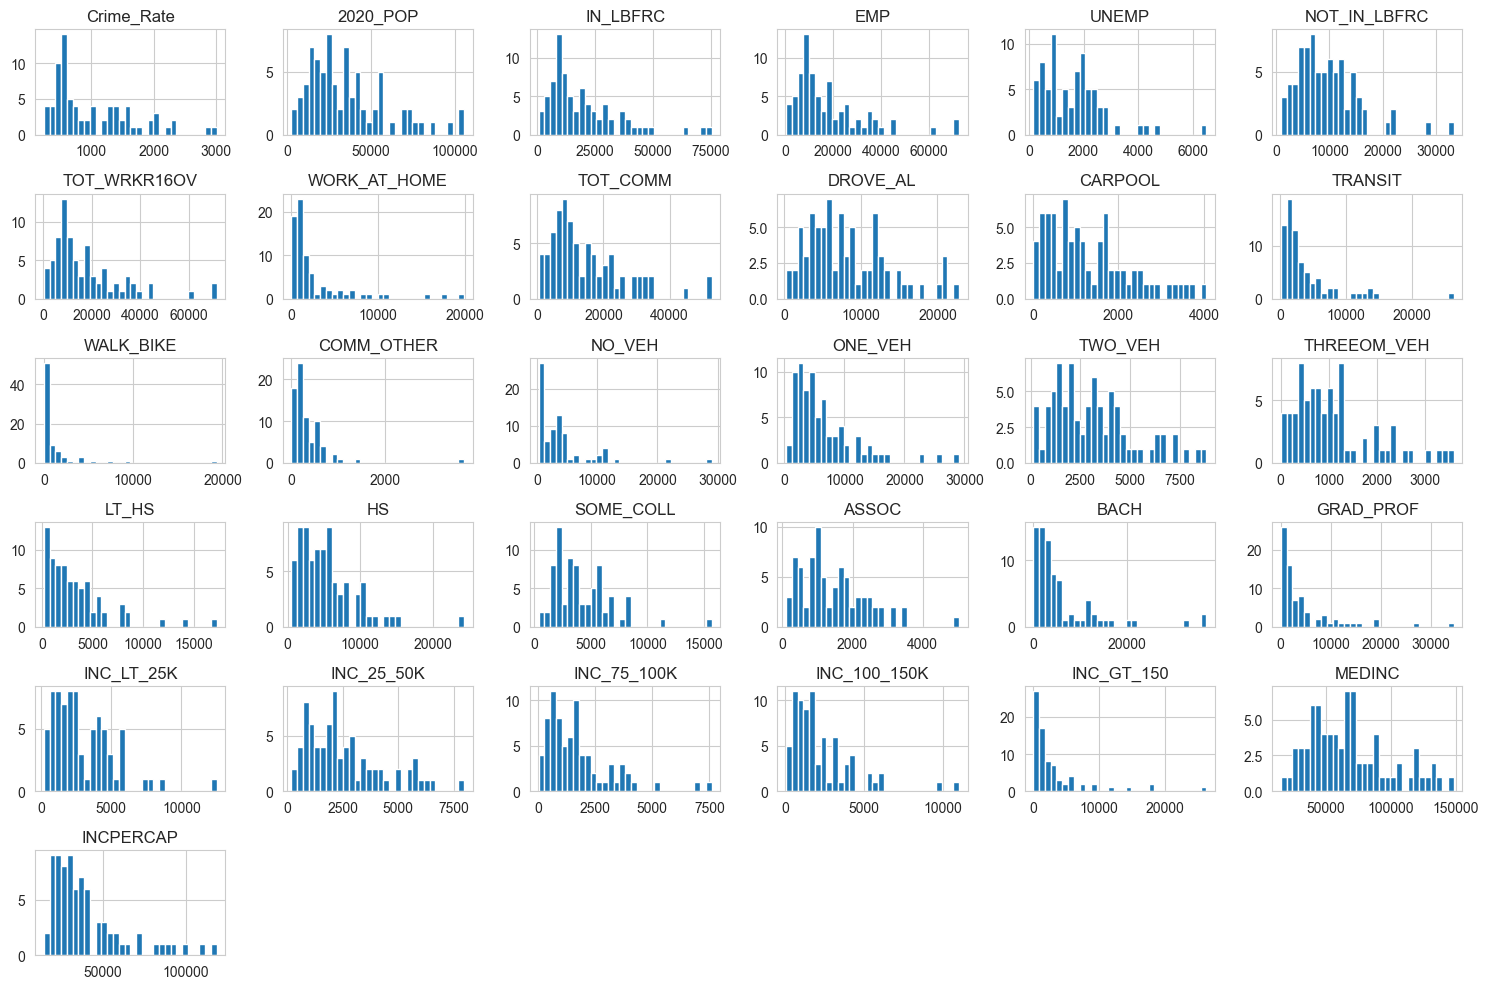

In [18]:
merged_df.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

#x-axis shows the value while y shows how many communities fall in that group

Most of the data is right skewed, including the population size of each community area. This could be motivation for us to only analyze smaller areas of Chicago as these populations may have more in common with each other by reducing outliers.

Variables were removed based on clear multicollinearity to create df_reduced. This does use a mix of all predictors and it's clear that some predictors have collinearity with others. We can either perform our analysis on all variables simultaneously or break the data down into separate categories (employment, transit, education) and compare the models after variable selection is performed to find the most impactful predictors. 

In [22]:

df_reduced = merged_df[[
                'EMP', 'UNEMP', #Employment predictors
                'WORK_AT_HOME' , 'DROVE_AL', 'CARPOOL', 'TRANSIT', 'WALK_BIKE', 'COMM_OTHER', #transit predictors
                'NO_VEH', 'ONE_VEH', 'TWO_VEH', 'THREEOM_VEH', #vehicle/transit predictors cont.
                'LT_HS', 'HS', 'SOME_COLL', 'ASSOC', 'BACH', 'GRAD_PROF', #Education predictors
                'INC_LT_25K', 'INC_25_50K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150', 'MEDINC', 'INCPERCAP',#Income predictors
                'Crime_Rate']]

#Employment predictors only
df_employ = merged_df[[
                'EMP', 'UNEMP', 
                'INC_LT_25K', 'INC_25_50K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150', 'MEDINC', 'INCPERCAP',
                'Crime_Rate']]

#Transit predictors only
df_transit = merged_df[[
                'WORK_AT_HOME' , 'DROVE_AL', 'CARPOOL', 'TRANSIT', 'WALK_BIKE', 'COMM_OTHER', 
                'NO_VEH', 'ONE_VEH', 'TWO_VEH', 'THREEOM_VEH',
                'Crime_Rate']]

#Education predictors only
df_edu = merged_df[[
                'LT_HS', 'HS', 'SOME_COLL', 'ASSOC', 'BACH', 'GRAD_PROF',
                'Crime_Rate']]



Use LASSO to perform variable selection on reduced_df. This can easily be adapted to perform LASSO on the dfs divided into categories.

In [23]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

X = df_reduced.drop(columns=['Crime_Rate'])
y = df_reduced['Crime_Rate']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit LASSO with cross-validation to find optimal alpha
lasso_cv = LassoCV(cv=10, max_iter=5000)
lasso_cv.fit(X_scaled, y)

# Get optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f'Optimal Alpha: {optimal_alpha}')

# Get coefficients
lasso_coef = pd.Series(lasso_cv.coef_, index=X.columns)

# Select nonzero coefficients
selected_features = lasso_coef[lasso_coef != 0].index.tolist()

print(f'Selected Features: {selected_features}')

Optimal Alpha: 14.382443084473076
Selected Features: ['UNEMP', 'CARPOOL', 'WALK_BIKE', 'THREEOM_VEH', 'SOME_COLL', 'INC_LT_25K', 'INC_25_50K', 'INC_GT_150', 'MEDINC']


Use stepwise to perform variable selection on reduced_df. This can also easily be adapted for the dfs divided into categories.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Define x y
X = df_reduced.drop(columns=['Crime_Rate'])
y = df_reduced['Crime_Rate']

#Standardize  features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

#Initialize the base model
model = LinearRegression()

#Forward selection
sfs_forward = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward')
sfs_forward.fit(X_train, y_train)

#Backward selection
sfs_backward = SequentialFeatureSelector(model, n_features_to_select=10, direction='backward')
sfs_backward.fit(X_train, y_train)

#Get selected features
features_forward = X.columns[sfs_forward.get_support()]
features_backward = X.columns[sfs_backward.get_support()]

print("Forward Selection Features:", list(features_forward))
print("Backward Elimination Features:", list(features_backward))




Forward Selection Features: ['UNEMP', 'WORK_AT_HOME', 'CARPOOL', 'TRANSIT', 'NO_VEH', 'LT_HS', 'BACH', 'INC_25_50K', 'INC_GT_150', 'MEDINC']
Backward Elimination Features: ['EMP', 'UNEMP', 'DROVE_AL', 'NO_VEH', 'THREEOM_VEH', 'LT_HS', 'INC_LT_25K', 'INC_25_50K', 'MEDINC', 'INCPERCAP']
